# Integration of FCDA with Weather and OSM

In this notebook we will integrate Floating car data with open weather data and osm street network to study accident risk for different tracks. The study provides analysis and visualisation that can help guide traffic safety strategies and measures.

## Load Floating Car Data 

At first, lets load floating car data using API along with the necessary library packages.

In [1]:
%reload_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import osmnx as ox
import folium 
from folium import plugins
import seaborn as sns
from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

Then lets request the tracks in the study area (Hamburg).

In [2]:
#Hamburg Bounding box
bbox = BboxSelector([
    8.4213643278001, # min_x
    53.3949251389001, # min_y
    10.3242585128001, # max_x
    53.9644376366001  # max_y
])

# issue a query
fcd_df = track_api.get_tracks(bbox=bbox, num_results=2000) # requesting 2000tracks inside the bbox
#display output
fcd_df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,CO2.unit,CO2.value,Calculated MAF.unit,Calculated MAF.value,Consumption.unit,Consumption.value,Engine Load.unit,Engine Load.value,GPS Accuracy.unit,GPS Accuracy.value,...,sensor.manufacturer,sensor.model,sensor.type,time,track.appVersion,track.begin,track.end,track.id,track.length,track.touVersion
0,kg/h,12.553278,g/s,16.250263,l/h,5.341820,%,48.627453,%,1.000000,...,Dodge,Caliber,car,2019-12-24T13:32:43,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN
1,kg/h,12.815187,g/s,16.589305,l/h,5.453271,%,47.450980,%,1.290161,...,Dodge,Caliber,car,2019-12-24T13:32:48,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN
2,kg/h,13.152298,g/s,17.025696,l/h,5.596722,%,49.019608,%,1.000000,...,Dodge,Caliber,car,2019-12-24T13:32:53,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN
3,kg/h,13.354478,g/s,17.287419,l/h,5.682756,%,48.985838,%,1.000000,...,Dodge,Caliber,car,2019-12-24T13:32:59,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN
4,kg/h,13.092870,g/s,16.948767,l/h,5.571434,%,48.814752,%,1.000000,...,Dodge,Caliber,car,2019-12-24T13:33:04,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,kg/h,13.472347,g/s,19.295189,l/h,5.732913,%,20.784313,%,4.000000,...,Opel,Zafira_1.6_CNG,car,2014-06-08T16:05:57,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN
1127,kg/h,14.855115,g/s,20.621344,l/h,6.321326,%,23.921568,%,8.000000,...,Opel,Zafira_1.6_CNG,car,2014-06-08T16:06:03,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN
1128,kg/h,2.549240,g/s,4.191152,l/h,1.084783,%,3.529412,%,5.000000,...,Opel,Zafira_1.6_CNG,car,2014-06-08T16:06:09,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN
1129,kg/h,8.536091,g/s,27.715616,l/h,3.632379,%,30.588236,%,5.000000,...,Opel,Zafira_1.6_CNG,car,2014-06-08T16:06:15,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN


In [3]:
([fcd_df['track.id'].unique])

[<bound method Series.unique of 0       5e08bcad5bc8db4289644058
 1       5e08bcad5bc8db4289644058
 2       5e08bcad5bc8db4289644058
 3       5e08bcad5bc8db4289644058
 4       5e08bcad5bc8db4289644058
                   ...           
 1126    53f20f6ee4b0d0547747d58f
 1127    53f20f6ee4b0d0547747d58f
 1128    53f20f6ee4b0d0547747d58f
 1129    53f20f6ee4b0d0547747d58f
 1130    53f20f6ee4b0d0547747d58f
 Name: track.id, Length: 65398, dtype: object>]

Extracting latitude and longitude track locations from the geometry stamp.

In [4]:
fcd_df['lat'] = fcd_df['geometry'].apply(lambda coord: coord.y)
fcd_df['lng'] = fcd_df['geometry'].apply(lambda coord: coord.x)
fcd_df

,CO2.unit,CO2.value,Calculated MAF.unit,Calculated MAF.value,Consumption.unit,Consumption.value,Engine Load.unit,Engine Load.value,GPS Accuracy.unit,GPS Accuracy.value,...,sensor.type,time,track.appVersion,track.begin,track.end,track.id,track.length,track.touVersion,lat,lng
0,kg/h,12.553278,g/s,16.250263,l/h,5.341820,%,48.627453,%,1.000000,...,car,2019-12-24T13:32:43,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551565,8.585379
1,kg/h,12.815187,g/s,16.589305,l/h,5.453271,%,47.450980,%,1.290161,...,car,2019-12-24T13:32:48,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551754,8.586735
2,kg/h,13.152298,g/s,17.025696,l/h,5.596722,%,49.019608,%,1.000000,...,car,2019-12-24T13:32:53,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551671,8.588132
3,kg/h,13.354478,g/s,17.287419,l/h,5.682756,%,48.985838,%,1.000000,...,car,2019-12-24T13:32:59,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551419,8.589484
4,kg/h,13.092870,g/s,16.948767,l/h,5.571434,%,48.814752,%,1.000000,...,car,2019-12-24T13:33:04,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551151,8.590854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,kg/h,13.472347,g/s,19.295189,l/h,5.732913,%,20.784313,%,4.000000,...,car,2014-06-08T16:05:57,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195340,9.285213
1127,kg/h,14.855115,g/s,20.621344,l/h,6.321326,%,23.921568,%,8.000000,...,car,2014-06-08T16:06:03,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195852,9.286047
1128,kg/h,2.549240,g/s,4.191152,l/h,1.084783,%,3.529412,%,5.000000,...,car,2014-06-08T16:06:09,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.196214,9.286828
1129,kg/h,8.536091,g/s,27.715616,l/h,3.632379,%,30.588236,%,5.000000,...,car,2014-06-08T16:06:15,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195948,9.287311


## Load Road Network from OSM 

Downloading road network from open street map, from which we will obtain speed limits and junction data that will be merged with floating car data

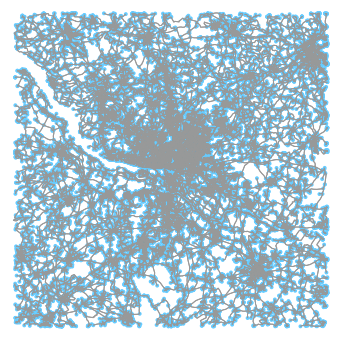

<module 'osmnx' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\osmnx\\__init__.py'>

In [5]:
G = ox.graph_from_point((53.5399925138901, 10.0000000000101), dist=50000, network_type='drive')
ox.plot_graph(G)
ox

Exploring the retrieved data frame by looking at the columns

In [6]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.columns

Index(['osmid', 'name', 'highway', 'oneway', 'length', 'geometry', 'maxspeed',
       'lanes', 'ref', 'bridge', 'junction', 'access', 'width', 'tunnel',
       'service', 'est_width', 'u', 'v', 'key'],
      dtype='object')

In [7]:
#checking data frame 
edges.head()

,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width,u,v,key
0,25258883,Glosterstraße,residential,False,39.780,"LINESTRING (9.67039 53.52337, 9.67026 53.52336...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,275251201,0
1,25258883,Glosterstraße,residential,False,87.301,"LINESTRING (9.67039 53.52337, 9.67105 53.52315...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,275251199,0
2,25258891,Glosterstraße,residential,False,54.662,"LINESTRING (9.67039 53.52337, 9.67048 53.52346...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,601508668,0
3,25258883,Glosterstraße,residential,False,39.780,"LINESTRING (9.66984 53.52350, 9.67026 53.52336...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251201,275251200,0
4,12541941,Schwalbenweg,residential,False,140.181,"LINESTRING (10.22896 53.95189, 10.22842 53.951...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114294785,114294813,0


Here we create a column and make a buffer to intercept with the FC data, we use a buffer of 10, it can be increased as per need.

In [8]:
prjedge = edges.to_crs('EPSG:25832')
prjedge['geometry'] = prjedge.geometry.buffer(10)
prjedge.head()

,osmid,name,highway,oneway,length,geometry,maxspeed,lanes,ref,bridge,junction,access,width,tunnel,service,est_width,u,v,key
0,25258883,Glosterstraße,residential,False,39.780,"POLYGON ((544436.090 5930692.045, 544435.029 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,275251201,0
1,25258883,Glosterstraße,residential,False,87.301,"POLYGON ((544492.769 5930687.625, 544493.518 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,275251199,0
2,25258891,Glosterstraße,residential,False,54.662,"POLYGON ((544440.253 5930716.542, 544443.987 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251200,601508668,0
3,25258883,Glosterstraße,residential,False,39.780,"POLYGON ((544437.632 5930712.170, 544443.274 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275251201,275251200,0
4,12541941,Schwalbenweg,residential,False,140.181,"POLYGON ((580624.530 5978775.864, 580619.422 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114294785,114294813,0


Reprojecting FC data  into same Coordinate Reference System with open street map data 

In [9]:
fcd_df = gpd.GeoDataFrame(
    fcd_df, geometry=gpd.points_from_xy(fcd_df.lng, fcd_df.lat),crs="EPSG:4326")
fcd_df = fcd_df.to_crs('EPSG:25832')
fcd_df

,CO2.unit,CO2.value,Calculated MAF.unit,Calculated MAF.value,Consumption.unit,Consumption.value,Engine Load.unit,Engine Load.value,GPS Accuracy.unit,GPS Accuracy.value,...,sensor.type,time,track.appVersion,track.begin,track.end,track.id,track.length,track.touVersion,lat,lng
0,kg/h,12.553278,g/s,16.250263,l/h,5.341820,%,48.627453,%,1.000000,...,car,2019-12-24T13:32:43,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551565,8.585379
1,kg/h,12.815187,g/s,16.589305,l/h,5.453271,%,47.450980,%,1.290161,...,car,2019-12-24T13:32:48,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551754,8.586735
2,kg/h,13.152298,g/s,17.025696,l/h,5.596722,%,49.019608,%,1.000000,...,car,2019-12-24T13:32:53,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551671,8.588132
3,kg/h,13.354478,g/s,17.287419,l/h,5.682756,%,48.985838,%,1.000000,...,car,2019-12-24T13:32:59,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551419,8.589484
4,kg/h,13.092870,g/s,16.948767,l/h,5.571434,%,48.814752,%,1.000000,...,car,2019-12-24T13:33:04,NaN,2019-12-24T13:32:43Z,2019-12-24T15:50:06Z,5e08bcad5bc8db4289644058,219.767934,NaN,53.551151,8.590854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,kg/h,13.472347,g/s,19.295189,l/h,5.732913,%,20.784313,%,4.000000,...,car,2014-06-08T16:05:57,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195340,9.285213
1127,kg/h,14.855115,g/s,20.621344,l/h,6.321326,%,23.921568,%,8.000000,...,car,2014-06-08T16:06:03,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195852,9.286047
1128,kg/h,2.549240,g/s,4.191152,l/h,1.084783,%,3.529412,%,5.000000,...,car,2014-06-08T16:06:09,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.196214,9.286828
1129,kg/h,8.536091,g/s,27.715616,l/h,3.632379,%,30.588236,%,5.000000,...,car,2014-06-08T16:06:15,NaN,2014-06-08T14:14:27Z,2014-06-08T16:06:21Z,53f20f6ee4b0d0547747d58f,190.571953,NaN,53.195948,9.287311


## Joining FC data with OSM data

Here we join floating car data with osm using intersect tool to segregate the networks within both data

In [10]:
fcd_osm_df = gpd.sjoin(fcd_df, prjedge, op='intersects')
fcd_osm_df

,CO2.unit,CO2.value,Calculated MAF.unit,Calculated MAF.value,Consumption.unit,Consumption.value,Engine Load.unit,Engine Load.value,GPS Accuracy.unit,GPS Accuracy.value,...,bridge,junction,access,width,tunnel,service,est_width,u,v,key
1436,NaN,NaN,NaN,NaN,NaN,NaN,%,43.492230,%,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657451672,1631850274,0
386,NaN,NaN,NaN,NaN,NaN,NaN,%,67.058824,%,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657451672,1631850274,0
387,NaN,NaN,NaN,NaN,NaN,NaN,%,35.608755,%,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657451672,1631850274,0
1152,NaN,NaN,g/s,25.138531,NaN,NaN,NaN,NaN,%,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657451672,1631850274,0
1152,NaN,NaN,g/s,25.138531,NaN,NaN,NaN,NaN,%,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1657451672,1631850274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,kg/h,35.295383,g/s,42.224192,l/h,15.019312,%,55.294117,%,3.0,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,2011579376,2011584833,0
1099,kg/h,35.295383,g/s,42.224192,l/h,15.019312,%,55.294117,%,3.0,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,2011584833,2011579376,0
1109,kg/h,54.538281,g/s,55.470692,l/h,23.207779,%,76.078430,%,3.0,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,354817352,2414363445,0
1109,kg/h,54.538281,g/s,55.470692,l/h,23.207779,%,76.078430,%,3.0,...,yes,NaN,NaN,NaN,NaN,NaN,NaN,2414363445,354817352,0


We create a function to sort the minimum value because in some highways there are 2 values for the max speed.

In [11]:
def getMin(inp):
    min = 10000
    for i in inp:
        if i < min:
            min = i
    return min        

Sorting the values from the maxspeed column and putting in an iterable list

In [12]:
speed_lst = []
for m in fcd_osm_df['maxspeed']:
     #print(m,type(m))
    if (type(m) ==str and len(m) <= 3):
        speed_lst.append(int(m))
    elif type(m) == list:
        conv = []
        for n in m:
            try:
                conv.append(int(n))
            except ValueError:
                conv.append(999)
        speed_lst.append(getMin(conv))        
        
    else:
        speed_lst.append(130)
            
print(speed_lst)   

[130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,

We add the speed_lst list as a column to the dataframe.
We create a new dataframe by extracting needed columns that can help in accident prediction.

In [13]:
fcd_osm_df['spdlimit'] = speed_lst
hbg_df = fcd_osm_df[['track.id', 'lat', 'lng','time', 'Speed.value', 'spdlimit','junction']]
hbg_df

,track.id,lat,lng,time,Speed.value,spdlimit,junction
1436,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15T09:57:26,129.963153,130,NaN
386,575d0172e4b0a69192a77d65,53.192228,9.283091,2016-05-05T13:54:16,180.999997,130,NaN
387,575d0172e4b0a69192a77d65,53.193851,9.285571,2016-05-05T13:54:21,180.000003,130,NaN
1152,558ebac4e4b07207d892393f,53.192653,9.283875,2015-06-27T12:32:07,129.000000,130,NaN
1152,558ebb18e4b07207d89263ca,53.192653,9.283875,2015-06-27T12:32:07,129.000000,130,NaN
...,...,...,...,...,...,...,...
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,2014-06-08T16:03:20,159.000000,70,NaN
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,2014-06-08T16:03:20,159.000000,70,NaN
1109,53f20f6ee4b0d0547747d58f,53.215968,9.317052,2014-06-08T16:04:17,158.000000,130,NaN
1109,53f20f6ee4b0d0547747d58f,53.215968,9.317052,2014-06-08T16:04:17,158.000000,130,NaN


Get summary statistics of the columns

In [14]:
hbg_df.describe()

,lat,lng,Speed.value,spdlimit
count,47214.000000,47214.000000,46226.000000,47214.000000
mean,53.355074,10.103519,75.091740,84.447198
std,0.149685,0.256281,38.743577,36.006861
min,53.092554,9.277137,0.000000,5.000000
25%,53.222374,9.957004,48.000000,50.000000
50%,53.372126,10.071679,82.417914,80.000000
75%,53.459333,10.313916,101.999999,120.000000
max,53.943502,10.730006,252.999996,130.000000


We extract the date and time from the timestamp using the inbuilt functions of pandas and datetime libraries.
We take the hour during which the track event occured and map them to different categories to later study if the vehicle was tracked during peak hours, early hours, regular hours and so on.

In [15]:
hbg_df= hbg_df.rename(columns = {'time':'timestamp'})

hbg_df['timestamp'] = pd.to_datetime(hbg_df['timestamp'])
hbg_df['eventDate'] = pd.to_datetime(hbg_df['timestamp'])
hbg_df['eventDate'] = hbg_df['eventDate'].dt.strftime('%Y-%m-%d')

hbg_df['e_hour'] = pd.to_datetime(hbg_df['timestamp'], format = '%H:%M:%S').dt.hour
hbg_df['ehourCat'] = 0

hbg_df['ehourCat'] = np.where((hbg_df['e_hour'] >= 0) & (hbg_df['e_hour'] < 6), 1, hbg_df['ehourCat'])
hbg_df['ehourCat'] = np.where((hbg_df['e_hour'] >= 6) & (hbg_df['e_hour'] < 20), 2, hbg_df['ehourCat'])
hbg_df['ehourCat'] = np.where((hbg_df['e_hour'] >= 20) & (hbg_df['e_hour'] < 24), 3, hbg_df['ehourCat'])

hbg_df

,track.id,lat,lng,timestamp,Speed.value,spdlimit,junction,eventDate,e_hour,ehourCat
1436,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15 09:57:26,129.963153,130,NaN,2019-04-15,9,2
386,575d0172e4b0a69192a77d65,53.192228,9.283091,2016-05-05 13:54:16,180.999997,130,NaN,2016-05-05,13,2
387,575d0172e4b0a69192a77d65,53.193851,9.285571,2016-05-05 13:54:21,180.000003,130,NaN,2016-05-05,13,2
1152,558ebac4e4b07207d892393f,53.192653,9.283875,2015-06-27 12:32:07,129.000000,130,NaN,2015-06-27,12,2
1152,558ebb18e4b07207d89263ca,53.192653,9.283875,2015-06-27 12:32:07,129.000000,130,NaN,2015-06-27,12,2
...,...,...,...,...,...,...,...,...,...,...
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,2014-06-08 16:03:20,159.000000,70,NaN,2014-06-08,16,2
1099,53f20f6ee4b0d0547747d58f,53.231911,9.342865,2014-06-08 16:03:20,159.000000,70,NaN,2014-06-08,16,2
1109,53f20f6ee4b0d0547747d58f,53.215968,9.317052,2014-06-08 16:04:17,158.000000,130,NaN,2014-06-08,16,2
1109,53f20f6ee4b0d0547747d58f,53.215968,9.317052,2014-06-08 16:04:17,158.000000,130,NaN,2014-06-08,16,2


Currently, we have features such as speed, location and the time when the track observation was made.Below we add weather data for the years 2018 and 2019, the period for which the track events occurred. https://www.worldweatheronline.com/. This will later be related to the time and date of track events

In [16]:
#pip install wwo_hist

In [17]:
from wwo_hist import retrieve_hist_data
frequency=1
start_date = '01-JAN-2014'
end_date = '01-DEC-2019'
api_key = 'a23ec9a138b84309995175213200306'
location_list = ['hamburg']

df = pd.DataFrame(retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True))
#this automatically exports csv containing weather data to working folder. 
#After exporting we rename the file to hamburg_weather.csv



Retrieving weather data for hamburg


Currently retrieving data for hamburg: from 2014-01-01 to 2014-01-31
Time elapsed (hh:mm:ss.ms) 0:00:02.954543
Currently retrieving data for hamburg: from 2014-02-01 to 2014-02-28
Time elapsed (hh:mm:ss.ms) 0:00:04.480371
Currently retrieving data for hamburg: from 2014-03-01 to 2014-03-31
Time elapsed (hh:mm:ss.ms) 0:00:06.181378
Currently retrieving data for hamburg: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:07.775973
Currently retrieving data for hamburg: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:09.124884
Currently retrieving data for hamburg: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:10.393690
Currently retrieving data for hamburg: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:12.135947
Currently retrieving data for hamburg: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:13.478498
Currently retrieving data for hamburg: from 2014-09-01 to 2014-09-30
Tim

Now, read the weather data and convert into data frame.

In [18]:
wthrdf = pd.read_csv('hamburg_weather.csv')
pd.DataFrame(wthrdf).columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location'],
      dtype='object')

We now extract Weather date and time from the date_time stamp
We follow similar strategy here to get the hour to equate it to the hour from the previous dataframe recorded by the different track events

In [19]:
wthrdf['date_time'] = wthrdf['date_time'].apply(lambda x : pd.to_datetime(str(x)))
wthrdf['weatherDate'] = wthrdf['date_time'].dt.date

wthrdf['date_time'] = wthrdf['date_time'].apply(lambda x : pd.to_datetime(str(x)))
wthrdf['weatherTime'] = wthrdf['date_time'].dt.time

wthrdf['w_hour'] = wthrdf['weatherTime'].apply(lambda x: x.hour)
wthrdf['hourCat'] = 0
wthrdf['hourCat'] = np.where((wthrdf['w_hour'] >= 0) & (wthrdf['w_hour'] < 6), 1, wthrdf['hourCat'])
wthrdf['hourCat'] = np.where((wthrdf['w_hour'] >= 6) & (wthrdf['w_hour'] < 20), 2, wthrdf['hourCat'])
wthrdf['hourCat'] = np.where((wthrdf['w_hour'] >= 20) & (wthrdf['w_hour'] < 24), 3, wthrdf['hourCat'])

wthrdf = wthrdf.drop_duplicates(subset = ['weatherDate', 'hourCat'], keep = 'first')
wthrdf['ehourCat'] = wthrdf['hourCat']
wthrdf['weatherDate'] = wthrdf['weatherDate']
wthrdf

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,tempC,visibility,winddirDegree,windspeedKmph,location,weatherDate,weatherTime,w_hour,hourCat,ehourCat
0,2014-01-01 00:00:00,4,0,0.0,5.8,2,0,09:02 AM,05:48 PM,09:37 AM,...,1,10,159,18,hamburg,2014-01-01,00:00:00,0,1,1
6,2014-01-01 06:00:00,4,0,0.0,5.8,2,0,09:02 AM,05:48 PM,09:37 AM,...,2,10,182,15,hamburg,2014-01-01,06:00:00,6,2,2
20,2014-01-01 20:00:00,4,0,0.0,5.8,2,0,09:02 AM,05:48 PM,09:37 AM,...,2,10,152,21,hamburg,2014-01-01,20:00:00,20,3,3
24,2014-01-02 00:00:00,7,2,0.0,1.9,2,2,09:48 AM,07:08 PM,09:37 AM,...,2,10,143,19,hamburg,2014-01-02,00:00:00,0,1,1
30,2014-01-02 06:00:00,7,2,0.0,1.9,2,2,09:48 AM,07:08 PM,09:37 AM,...,5,10,141,22,hamburg,2014-01-02,06:00:00,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51822,2019-11-30 06:00:00,6,-1,0.0,3.9,2,20,12:51 PM,08:34 PM,09:11 AM,...,2,10,255,10,hamburg,2019-11-30,06:00:00,6,2,2
51836,2019-11-30 20:00:00,6,-1,0.0,3.9,2,20,12:51 PM,08:34 PM,09:11 AM,...,1,10,252,8,hamburg,2019-11-30,20:00:00,20,3,3
51840,2019-12-01 00:00:00,5,1,0.0,2.0,2,26,01:29 PM,09:41 PM,09:13 AM,...,2,10,243,7,hamburg,2019-12-01,00:00:00,0,1,1
51846,2019-12-01 06:00:00,5,1,0.0,2.0,2,26,01:29 PM,09:41 PM,09:13 AM,...,2,5,236,6,hamburg,2019-12-01,06:00:00,6,2,2


To merge the two dataframes on a mutual column, we create an extra column with the same name weatherDate in our previous dataframe hbg_df.
This is followed by creating a new data frame that merges our initial dataframe with the weather dataframe.

In [20]:
hbg_df['weatherDate'] = hbg_df['eventDate']

hbg_df.weatherDate = pd.to_datetime(hbg_df.weatherDate)
wthrdf.weatherDate = pd.to_datetime(wthrdf.weatherDate)

fcd_wthr_df=pd.merge(hbg_df,wthrdf, on=['weatherDate', 'ehourCat'], how='outer')
fcd_wthr_df

,track.id,lat,lng,timestamp,Speed.value,spdlimit,junction,eventDate,e_hour,ehourCat,...,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,weatherTime,w_hour,hourCat
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15 09:57:26,129.963153,130.0,NaN,2019-04-15,9.0,2,...,0.0,1031,3,10,77,15,hamburg,06:00:00,6,2
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15 09:57:31,128.404393,130.0,NaN,2019-04-15,9.0,2,...,0.0,1031,3,10,77,15,hamburg,06:00:00,6,2
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15 09:57:35,126.000004,130.0,NaN,2019-04-15,9.0,2,...,0.0,1031,3,10,77,15,hamburg,06:00:00,6,2
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15 09:57:40,127.000000,130.0,NaN,2019-04-15,9.0,2,...,0.0,1031,3,10,77,15,hamburg,06:00:00,6,2
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15 09:57:45,128.000002,130.0,NaN,2019-04-15,9.0,2,...,0.0,1031,3,10,77,15,hamburg,06:00:00,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53660,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2,...,0.0,1019,2,10,255,10,hamburg,06:00:00,6,2
53661,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,3,...,0.0,1022,1,10,252,8,hamburg,20:00:00,20,3
53662,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1,...,0.0,1022,2,10,243,7,hamburg,00:00:00,0,1
53663,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2,...,0.0,1022,2,5,236,6,hamburg,06:00:00,6,2


Here we create a new dataframe consisting of the needed columns from FCD, OSM, and Weather data

In [21]:
hmbg_df = fcd_wthr_df[['track.id', 'lat', 'lng','eventDate', 'e_hour','ehourCat','Speed.value',
                       'spdlimit','junction','precipMM','visibility','windspeedKmph']]

In [22]:
#save a copy after choosing the varaibles you want to consider for final prediction.
writer = pd.ExcelWriter('hamburg-Fcd_wthr_osm-data.xlsx')
hmbg_df.to_excel(writer, index = False, sheet_name = 'Sheet1')
writer.save()

Some of the columns do not have enough entries compared to our initial entries. This is due to the fact that the weather scraper could not find information for all the hours when the track events were recorded by the FCD sytems. Hence, we replace the NaN data for which we could not find information with the Mode values, that is the most frequently occuring values of certain columns which we will use for our final prediction.

In [23]:
pd.options.mode.chained_assignment = None
for column in ['precipMM', 'visibility', 'windspeedKmph']:
    hmbg_df[column].fillna(fcd_wthr_df[column].mode(), inplace=True)

convert NAN values to zero,so as to have only intergers in the dataframe

In [24]:
hmbg_df.replace([np.inf, -np.inf], np.nan, inplace=True)
hmbg_df.fillna(0, inplace=True)
hmbg_df

,track.id,lat,lng,eventDate,e_hour,ehourCat,Speed.value,spdlimit,junction,precipMM,visibility,windspeedKmph
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15,9.0,2,129.963153,130.0,0,0.0,10,15
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15,9.0,2,128.404393,130.0,0,0.0,10,15
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15,9.0,2,126.000004,130.0,0,0.0,10,15
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15,9.0,2,127.000000,130.0,0,0.0,10,15
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15,9.0,2,128.000002,130.0,0,0.0,10,15
...,...,...,...,...,...,...,...,...,...,...,...,...
53660,0,0.000000,0.000000,0,0.0,2,0.000000,0.0,0,0.0,10,10
53661,0,0.000000,0.000000,0,0.0,3,0.000000,0.0,0,0.0,10,8
53662,0,0.000000,0.000000,0,0.0,1,0.000000,0.0,0,0.0,10,7
53663,0,0.000000,0.000000,0,0.0,2,0.000000,0.0,0,0.0,5,6


Get summary statistics for the columns

In [25]:
hmbg_df.describe()

,lat,lng,e_hour,ehourCat,Speed.value,spdlimit,precipMM,visibility,windspeedKmph
count,53665.000000,53665.000000,53665.000000,53665.000000,53665.000000,53665.000000,53665.000000,53665.000000,53665.000000
mean,46.941330,8.888988,11.557961,2.044405,64.682582,74.295910,0.007398,9.727886,14.072953
std,17.352089,3.294531,5.750868,0.350674,44.342848,43.529926,0.089231,1.439014,7.834012
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.152258,9.935048,8.000000,2.000000,28.000000,50.000000,0.000000,10.000000,9.000000
50%,53.337286,10.033098,13.000000,2.000000,69.568802,60.000000,0.000000,10.000000,12.000000
75%,53.451681,10.248755,16.000000,2.000000,100.000000,120.000000,0.000000,10.000000,18.000000
max,53.943502,10.730006,23.000000,3.000000,252.999996,130.000000,8.400000,20.000000,52.000000


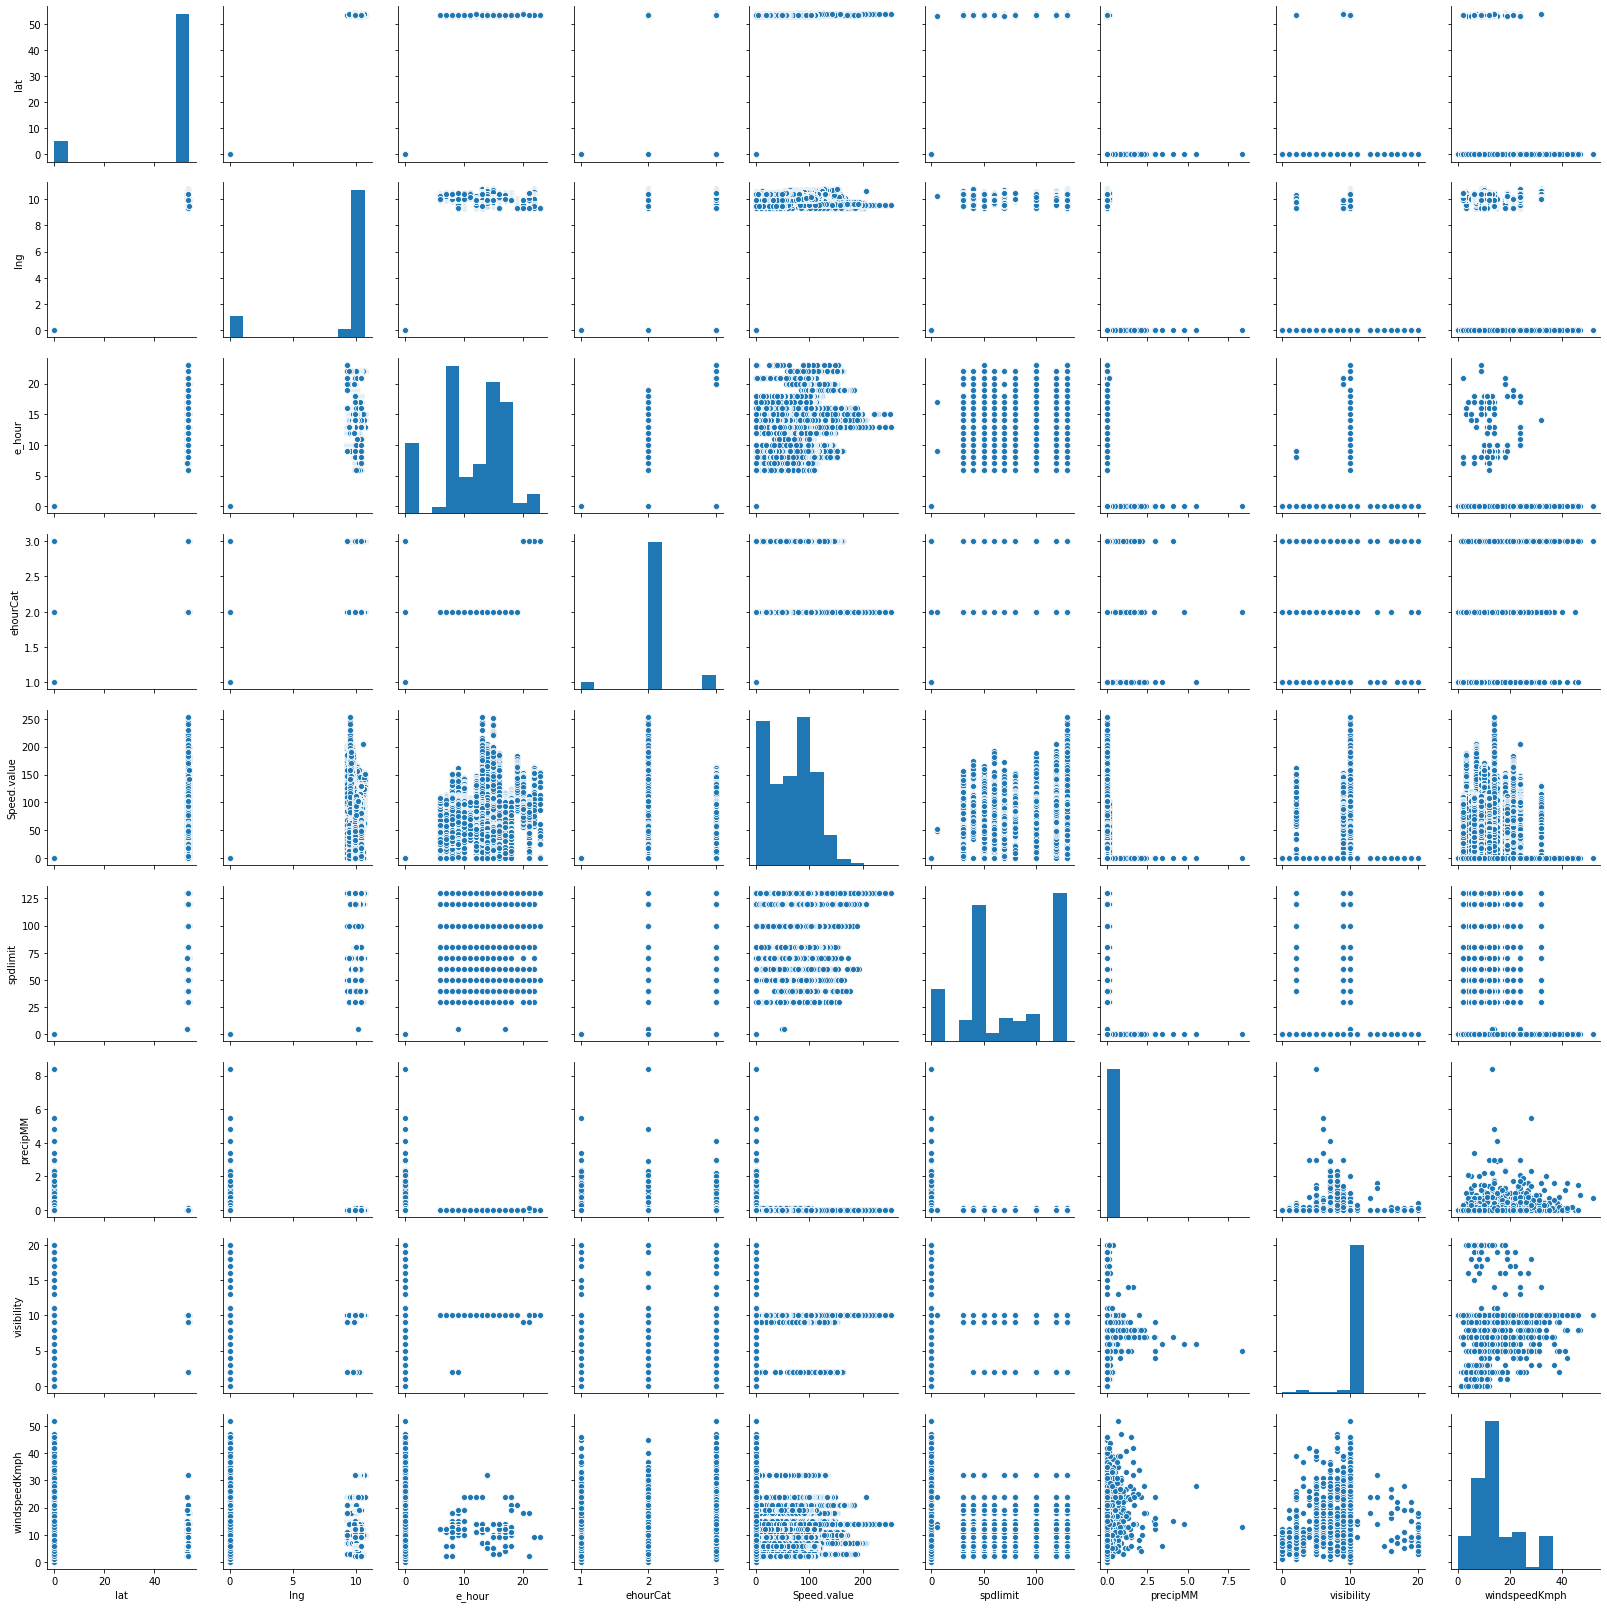

In [26]:
#lets look at the realationships between our variables
sns.pairplot(hmbg_df)

We create flags to categorize our columns into 0 or 1 depending on the condition defined. We created a new column showing instances of overspeed, we get the difference between the track speeds and speed limits, we give a flag of 0 if speed is not exceeded and 1 if otherwise. For junctions, the data has some roundabouts and intersections, we give a flag of 0 if its not a junction. We now look at weather columns: For visibilty, values less than or equal to 10 are flaged 0, we refer to https://www.sciencedirect.com/science/article/pii/S0386111216300681 were normal visibity is said to be >= 10mi. For windspeed we creating our flags with reference to https://www.weather.gov/dmx/dsswind, were windspeeds execeeding 30mph=48.28kmph are dangerous for driving. We also classify precipitation with values less than 0.5mm given a flag of 0, since at 0.5mm indicates small rains. https://www.ipma.pt/pt/educativa/faq/meteorologia/previsao/faqdetail.html?f=/pt/educativa/faq/meteorologia/previsao/faq_0033.html


In [27]:
pd.options.mode.chained_assignment = None
hmbg_df['hasoverspeed'] = np.where(hmbg_df['Speed.value'] < hmbg_df['spdlimit'], 0,1)   
hmbg_df['visibility'] = np.where(hmbg_df['visibility'] <= 10, 0, 1)
hmbg_df['windspeedKmph'] = np.where(hmbg_df.windspeedKmph >= 48.28, 1, 0)
hmbg_df['precipMM'] = np.where(hmbg_df.precipMM >= 0.5, 1, 0)
hmbg_df['junction'] = np.where(hmbg_df.junction == 0, 0, 1)    
hmbg_df

,track.id,lat,lng,eventDate,e_hour,ehourCat,Speed.value,spdlimit,junction,precipMM,visibility,windspeedKmph,hasoverspeed
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15,9.0,2,129.963153,130.0,0,0,0,0,0
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15,9.0,2,128.404393,130.0,0,0,0,0,0
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15,9.0,2,126.000004,130.0,0,0,0,0,0
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15,9.0,2,127.000000,130.0,0,0,0,0,0
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15,9.0,2,128.000002,130.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53660,0,0.000000,0.000000,0,0.0,2,0.000000,0.0,0,0,0,0,1
53661,0,0.000000,0.000000,0,0.0,3,0.000000,0.0,0,0,0,0,1
53662,0,0.000000,0.000000,0,0.0,1,0.000000,0.0,0,0,0,0,1
53663,0,0.000000,0.000000,0,0.0,2,0.000000,0.0,0,0,0,0,1


Here we drop the redundant rows for which weather data did not have track events. Here we delete all columns that dont have track id's

In [28]:
hmbg_df = hmbg_df.drop(hmbg_df.index[47214:])
hmbg_df

,track.id,lat,lng,eventDate,e_hour,ehourCat,Speed.value,spdlimit,junction,precipMM,visibility,windspeedKmph,hasoverspeed
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15,9.0,2,129.963153,130.0,0,0,0,0,0
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15,9.0,2,128.404393,130.0,0,0,0,0,0
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15,9.0,2,126.000004,130.0,0,0,0,0,0
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15,9.0,2,127.000000,130.0,0,0,0,0,0
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15,9.0,2,128.000002,130.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47209,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0
47210,5ae4ee3844ea8508c5b49c9b,53.221337,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0
47211,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0
47212,5ae4ee3844ea8508c5b49c9b,53.222685,10.402662,2018-04-28,16.0,2,3.313225,30.0,0,0,0,0,0


We now map all the columns to which we accorded numerical flags into thier equivalent text flags that are more understandable.
We creat a new dataframe showing text flags that help one understand conditions under which the tracks took place.

In [29]:
hmbrgdf= hmbg_df.copy()

hmbrgdf['hasoverspeed'] = np.where(hmbg_df.hasoverspeed == 1, 'Yes', 'No')
hmbrgdf['ehourCat'] = hmbg_df['ehourCat'].map({1: 'Early', 2: 'PeakM', 3: 'RegularM'})
hmbrgdf['visibility'] = np.where(hmbg_df.visibility == 0, 'High', 'Low')
hmbrgdf['precipMM'] = np.where(hmbg_df.precipMM == 1, 'Rainy', 'small/No_rain')
hmbrgdf['windspeedKmph'] = np.where(hmbg_df.windspeedKmph == 1, 'Windy', 'lessWindy')
hmbrgdf['junction'] = np.where(hmbg_df.junction == 0, 'No', ' Yes')
hmbrgdf

,track.id,lat,lng,eventDate,e_hour,ehourCat,Speed.value,spdlimit,junction,precipMM,visibility,windspeedKmph,hasoverspeed
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15,9.0,PeakM,129.963153,130.0,No,small/No_rain,High,lessWindy,No
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15,9.0,PeakM,128.404393,130.0,No,small/No_rain,High,lessWindy,No
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15,9.0,PeakM,126.000004,130.0,No,small/No_rain,High,lessWindy,No
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15,9.0,PeakM,127.000000,130.0,No,small/No_rain,High,lessWindy,No
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15,9.0,PeakM,128.000002,130.0,No,small/No_rain,High,lessWindy,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47209,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,PeakM,0.000000,30.0,No,small/No_rain,High,lessWindy,No
47210,5ae4ee3844ea8508c5b49c9b,53.221337,10.402866,2018-04-28,16.0,PeakM,0.000000,30.0,No,small/No_rain,High,lessWindy,No
47211,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,PeakM,0.000000,30.0,No,small/No_rain,High,lessWindy,No
47212,5ae4ee3844ea8508c5b49c9b,53.222685,10.402662,2018-04-28,16.0,PeakM,3.313225,30.0,No,small/No_rain,High,lessWindy,No


We make reference to the dataframe that has numerical flags and create a new dataframe with extracted coulumns that help indicate possible instances of accident occurance.

In [30]:
Xdf =hmbg_df.loc[:,['ehourCat','junction', 'visibility','windspeedKmph','hasoverspeed',  'precipMM']]
Xdf

,ehourCat,junction,visibility,windspeedKmph,hasoverspeed,precipMM
0,2,0,0,0,0,0
1,2,0,0,0,0,0
2,2,0,0,0,0,0
3,2,0,0,0,0,0
4,2,0,0,0,0,0
...,...,...,...,...,...,...
47209,2,0,0,0,0,0
47210,2,0,0,0,0,0
47211,2,0,0,0,0,0
47212,2,0,0,0,0,0


check data types before applying clustering algorithim.

In [31]:
Xdf.dtypes

ehourCat         int64
junction         int32
visibility       int32
windspeedKmph    int32
hasoverspeed     int32
precipMM         int32
dtype: object

Since the data is unlabeled, we opt for unsupervised learning approach using clustering techniques. We use the K-means algorithim. While different variation of K-Means exists, we used the Expectation Maximization method. In order to get better convergence of our datapoints to centroid, we also increased the number of iterations from a default of 300 to 2000. The Expectation Maximization algorithm can be found here: https://en.wikipedia.org/wiki/Expectation–maximization_algorithm

We create two sets of clusters here: one for low likelihood accident instance whereas the other one for high likelihood accident instance.

In [32]:
from sklearn.cluster import KMeans
X = Xdf.values.astype(np.float)
kmeans = KMeans(n_clusters = 2, max_iter = 2000, algorithm = 'full').fit(X)
kmf2labels = kmeans.labels_
kmf2labels = kmf2labels.tolist()
print('Finished clustering using K-Means')

Finished clustering using K-Means


In [33]:
len(kmf2labels)

47214

So, we now have labels for all the track points from our dataset and the lables are crucial towards understanding an if an accident would take place or not during the mobility of the vehicle.

Let us join this list of labels to the dataframe to study them carefully. First we add the lables into the a new column and than map the labels to accident severity of high or low.

In [34]:
Xdf['clusters'] = kmf2labels
Xdf

,ehourCat,junction,visibility,windspeedKmph,hasoverspeed,precipMM,clusters
0,2,0,0,0,0,0,1
1,2,0,0,0,0,0,1
2,2,0,0,0,0,0,1
3,2,0,0,0,0,0,1
4,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...
47209,2,0,0,0,0,0,1
47210,2,0,0,0,0,0,1
47211,2,0,0,0,0,0,1
47212,2,0,0,0,0,0,1


Take note of the clusters and the labels, i have realised that each time i re-run the notebook, the labels might interchange, so always adjust according to label and data so that you give right undersatnding of accident risk.

In [42]:
Xdf['clusters'] = kmf2labels
hmbg_df['clusters'] = Xdf['clusters']
hmbg_df['Accident_risk'] = hmbg_df['clusters'].map({0: 'high', 1: 'low'}) # this can interchange when you re-run the notebook, always change this mapping according to result of cluster labels.
hmbg_df

,track.id,lat,lng,eventDate,e_hour,ehourCat,Speed.value,spdlimit,junction,precipMM,visibility,windspeedKmph,hasoverspeed,clusters,Accident_risk
0,5cdcea6d44ea85030283f9dd,53.193170,9.284603,2019-04-15,9.0,2,129.963153,130.0,0,0,0,0,0,1,low
1,5cdcea6d44ea85030283f9dd,53.194387,9.286511,2019-04-15,9.0,2,128.404393,130.0,0,0,0,0,0,1,low
2,5cdcea6d44ea85030283f9dd,53.195467,9.288158,2019-04-15,9.0,2,126.000004,130.0,0,0,0,0,0,1,low
3,5cdcea6d44ea85030283f9dd,53.196614,9.289890,2019-04-15,9.0,2,127.000000,130.0,0,0,0,0,0,1,low
4,5cdcea6d44ea85030283f9dd,53.197769,9.291647,2019-04-15,9.0,2,128.000002,130.0,0,0,0,0,0,1,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47209,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0,1,low
47210,5ae4ee3844ea8508c5b49c9b,53.221337,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0,1,low
47211,5ae4ee3844ea8508c5b49c9b,53.221336,10.402866,2018-04-28,16.0,2,0.000000,30.0,0,0,0,0,0,1,low
47212,5ae4ee3844ea8508c5b49c9b,53.222685,10.402662,2018-04-28,16.0,2,3.313225,30.0,0,0,0,0,0,1,low


Let's plot the tracks to visualise predictions of tracks that were at high risk of accident occurance.

In [45]:
location = hmbg_df['lat'].mean(),hmbg_df['lng'].mean()
m = folium.Map(location=location,zoom_start=10)

folium.TileLayer('cartodbpositron').add_to(m)

clust_colours = ['#e31a1c', '#b2df8a']

for i in range(0,len(hmbg_df)):
    colouridx = hmbg_df['clusters'].iloc[i]
    if colouridx == -1:
        pass
    else:
        col = clust_colours[colouridx%len(clust_colours)]
        folium.CircleMarker([hmbg_df['lat'].iloc[i,],hmbg_df['lng'].iloc[i,]], radius = 0.2, color = col, fill = col).add_to(m)
m.save('fcd_acc_predict.html')       

It would be nice to integrate the visualization of past accident occurance with our predictions so as to further analyse how vehicles are moving. This gives more insight of possible re-occurance of incidents. We relate the 2018 accident report heat map with the tracks.

In [46]:
accdf = pd.read_csv('Acc_2018_Hamburg.csv', usecols = ['Latitude','Longitude'])

In [47]:
df_map = accdf.copy()
df_map['count']=1
df_map[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().sort_values('count', ascending=False).head(10)

,,count
Latitude,Longitude,
53.617834,9.907520,3
53.603314,9.986781,2
53.533046,9.878842,2
53.627695,9.888583,2
53.627745,10.006871,2
53.590939,9.987652,2
53.620440,9.908195,2
53.564817,9.901476,2
53.569520,10.123804,2


Lets plot accident occurance heat map for the year 2018 to relate history accident occurance with  track movement conditions.

In [48]:
from folium.plugins import HeatMap

HeatMap(data=df_map[['Latitude', 'Longitude', 'count']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(), radius=5, max_zoom=10).add_to(m)
m.save('fcdtracks_2018heatmap.html')

it should be noted that hamburg did not have a good number of tracks and so most of the tracks are seen in the outcasts of hamburg. However a few tracks fall in the hamburg region and can be related to past accidents occurance. This helps to visualize and build intuitions about current vehicle movements and thier proneness to accidents. Vehicles that are moving with high risk to accidents in critical areas show that safety is still lacking in those areas. Also, such visualisation helps to see whether safety measures put in place are effective in regards to reducing accident risk.

Lets see the relationship between the day hour and our predictions. 

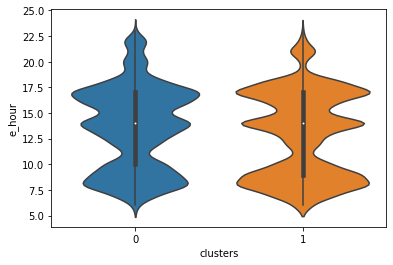

In [49]:
sns.violinplot(x = 'clusters', y = 'e_hour', data =hmbg_df)

Our predictions show that low and high risk of accident occurance of the tracks under study is experienced can be experienced at any time of day. So avoidance of accident is dependent on drivers behavior during any weather condition at a given location.

Let's have a look at another intuitive visualisation using pydeck and mapbox to easily understand our prediction results.

In [50]:
import pydeck as pdk

accs_df = pd.DataFrame(hmbg_df)

layer = pdk.Layer(
    'ScatterplotLayer',
    data=accs_df,
    get_position='[lng, lat]',
    auto_highlight=True,
    get_radius=10,          # Radius is given in meters
    get_fill_color='[clusters * 255, (1 - clusters) * 255, (1 - clusters) * 128]',  # Set an RGBA value for fill
    pickable=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=9.967,
    latitude=53.433, 
    zoom=10,
    min_zoom=10,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

r = pdk.Deck(
    width=200, 
    layers=[layer], 
    initial_view_state=view_state, mapbox_key= 'pk.eyJ1IjoibTIwMTkwNjQ5IiwiYSI6ImNrOTJzZTN4aDA2d2UzZnBnYWJsdWJuMzEifQ.-D3TfGOYZdjqFZrG8qlWhA'
)
r.to_html('AccRisk_tracks_hamburg.html', iframe_width=1000)

'C:\\Users\\Edwige\\Desktop\\hamburg\\data\\Final note books\\AccRisk_tracks_hamburg.html'

Zooming in the map shows a visualisation of the tracks proneness to accidents. Using the popup, you can see were the accident risk is high or low. Tracks that were prone to high accident risk indicate that thier movement at that time could have easily led to an accident. This could be possibly due to the fact that they were overspeeding in bad weather conditions or at junctions.

Hence, in conclusion, floating car data can be integrated with different other data like osm and weather and history accident reports to critically analyse the movement of vehicles. Patterns reaveled from intergating various data can help to identify routes were the population is at risk and can as well identify routes were drivers violet traffic guidelines. This information can help reponsible authorities in employing meausres for traffic safety in those areas.